##  Practice

### The provided code snippet outlines a comprehensive portfolio analysis system that includes advanced metrics, risk modeling, rolling analysis, Monte Carlo simulation, and dynamic rebalancing, along with clear visualizations and reporting. It concludes with saving key results like portfolio weights and rolling metrics to CSV files for further use.

Here's a summary of its key features:

Optimization Strategies:
Long-only portfolio optimization.
Portfolios allowing short selling and constrained short selling.
Value-at-Risk (VaR) and drawdown optimization.
Risk Metrics:
Sharpe and Sortino ratios.
Conditional Value at Risk (CVaR).
Annualized volatility and maximum drawdown.
Efficient Frontier:
Calculation of risk-return trade-offs across various target returns.
Advanced Analysis:
Monte Carlo simulation for forward portfolio value projection.
Rolling metrics for volatility, Sharpe ratio, and Sortino ratio.
Correlation analysis for asset dependencies.
Dynamic Rebalancing:
Analyzing periodic rebalancing returns with a chosen frequency.
Visualization:
Rolling metrics trends, efficient frontier, Monte Carlo paths, and correlation heatmaps.
Reports:
CSV outputs for weights, rolling metrics, and main results.
Example usage demonstrates functionality and readability.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.optimize as sco
import matplotlib.pyplot as plt
import requests_cache
import yfinance as yf
import pandas_datareader as pdr
import requests_cache
from typing import List, Dict, Union, Tuple
import seaborn as sns
from scipy import stats
session = requests_cache.CachedSession()

In [2]:
%config InlineBackend.figure_format = 'retina'
%precision 4
pd.options.display.float_format = '{:.4f}'.format

In [3]:
def comprehensive_portfolio_analysis(
    tickers=None, 
    start_date='2020', 
    end_date='2024', 
    use_dow=False,
    risk_free_rate=0.02,
    confidence_level=0.95,
    rebalance_frequency='M',
    monte_carlo_sims=5000
):
    """
    Enhanced portfolio analysis including advanced risk metrics, Monte Carlo simulation,
    and dynamic rebalancing analysis.
    
    Parameters:
    -----------
    tickers : str or list, optional
        Space-separated string or list of ticker symbols
    start_date : str, default '2020'
        Start date for analysis
    end_date : str, default '2022'
        End date for analysis
    use_dow : bool, default False
        If True, uses Dow Jones Industrial Average stocks
    risk_free_rate : float, default 0.02
        Annual risk-free rate for calculations
    confidence_level : float, default 0.95
        Confidence level for VaR and CVaR calculations
    rebalance_frequency : str, default 'M'
        Frequency for rebalancing analysis ('D', 'W', 'M', 'Q', 'Y')
    monte_carlo_sims : int, default 1000
        Number of Monte Carlo simulations
    
    Returns:
    --------
    dict : Contains all optimization results and analysis metrics
    """
    
    # Original helper functions
    def port_sharpe(x, r, ppy, tgt):
        rp = r.dot(x)
        er = rp.sub(tgt).dropna()
        return np.sqrt(ppy) * er.mean() / er.std()
    
    def port_sharpe_neg(x, r, ppy, tgt):
        return -1 * port_sharpe(x, r, ppy, tgt)
    
    def port_var(x, r, q):
        return r.dot(x).quantile(q)
    
    def port_var_neg(x, r, q):
        return -1 * port_var(x=x, r=r, q=q)
    
    def port_draw_down_max(x, r):
        rp = r.dot(x)
        price = rp.add(1).cumprod()
        cum_max = price.cummax()
        draw_down = (cum_max - price) / cum_max
        return draw_down.max()
    
    def port_vol(x, r, ppy):
        return np.sqrt(ppy) * r.dot(x).std()
    
    def port_mean(x, r, ppy):
        return ppy * r.dot(x).mean()
    
    # New helper functions
    def calculate_cvar(returns, weights, confidence_level):
        """Calculate Conditional Value at Risk"""
        portfolio_returns = returns.dot(weights)
        var = np.percentile(portfolio_returns, (1 - confidence_level) * 100)
        return -portfolio_returns[portfolio_returns <= var].mean()
    
    def calculate_sortino_ratio(returns, weights, risk_free_rate, periods_per_year=252):
        """Calculate Sortino Ratio"""
        portfolio_returns = returns.dot(weights)
        excess_returns = portfolio_returns - risk_free_rate/periods_per_year
        downside_returns = excess_returns[excess_returns < 0]
        downside_std = np.sqrt(np.mean(downside_returns**2)) * np.sqrt(periods_per_year)
        return np.mean(excess_returns) * periods_per_year / downside_std if downside_std != 0 else np.inf
    
    def calculate_rolling_metrics(returns, weights, window=252):
        """Calculate rolling performance metrics"""
        portfolio_returns = returns.dot(weights)
        rolling_metrics = pd.DataFrame({
            'Rolling_Volatility': portfolio_returns.rolling(window).std() * np.sqrt(252),
            'Rolling_Sharpe': portfolio_returns.rolling(window).apply(
                lambda x: np.sqrt(252) * x.mean() / x.std() if x.std() != 0 else np.nan
            ),
            'Rolling_Sortino': portfolio_returns.rolling(window).apply(
                lambda x: np.sqrt(252) * x.mean() / x[x < 0].std() if len(x[x < 0]) > 0 else np.nan
            )
        })
        return rolling_metrics
    
    def monte_carlo_simulation(returns, weights, simulations=5000, days=252):
        """Perform Monte Carlo simulation for portfolio returns"""
        portfolio_returns = returns.dot(weights)
        mean_return = portfolio_returns.mean()
        std_return = portfolio_returns.std()
        
        simulated_returns = np.random.normal(
            mean_return, 
            std_return, 
            size=(simulations, days)
        )
        
        simulated_paths = np.cumprod(1 + simulated_returns, axis=1)
        return simulated_paths
    
    # Data collection and preparation
    if use_dow:
        wiki = pd.read_html('https://en.wikipedia.org/wiki/Dow_Jones_Industrial_Average')
        tickers = wiki[2]['Symbol'].to_list()
    elif isinstance(tickers, str):
        tickers = tickers.split()
    
    # Download and prepare data
    data = yf.download(tickers=tickers, progress=False)
    data = (data
            .assign(Date=lambda x: x.index.tz_localize(None))
            .set_index('Date')
            .rename_axis(columns=['Variable', 'Ticker']))
    
    returns = data['Adj Close'].pct_change().loc[start_date:end_date].dropna()
    
    results = {}
    
    
    # 1. Long-only portfolio optimization
    res_sharpe_1 = sco.minimize(
        fun=port_sharpe_neg,
        x0=np.ones(returns.shape[1]) / returns.shape[1],
        args=(returns, 252, 0),
        bounds=[(0,1) for _ in range(returns.shape[1])],
        constraints=({'type': 'eq', 'fun': lambda x: x.sum() - 1})
    )
    results['long_only_sharpe'] = {
        'weights': res_sharpe_1['x'],
        'sharpe_ratio': port_sharpe(res_sharpe_1['x'], returns, 252, 0)
    }
    
    # 2. Portfolio with short selling allowed
    res_sharpe_2 = sco.minimize(
        fun=port_sharpe_neg,
        x0=np.ones(returns.shape[1]) / returns.shape[1],
        args=(returns, 252, 0),
        bounds=[(-.1,1.5) for _ in range(returns.shape[1])],
        constraints=({'type': 'eq', 'fun': lambda x: x.sum() - 1})
    )
    results['short_allowed_sharpe'] = {
        'weights': res_sharpe_2['x'],
        'sharpe_ratio': port_sharpe(res_sharpe_2['x'], returns, 252, 0)
    }
    
    # 3. Limited short selling portfolio
    res_sharpe_3 = sco.minimize(
        fun=port_sharpe_neg,
        x0=np.ones(returns.shape[1]) / returns.shape[1],
        args=(returns, 252, 0),
        bounds=[(-0.3,1.3) for _ in range(returns.shape[1])],
        constraints=(
            {'type': 'eq', 'fun': lambda x: x.sum() - 1},
            {'type': 'ineq', 'fun': lambda x: x[x < 0].sum() + 0.3}
        )
    )
    results['limited_short_sharpe'] = {
        'weights': res_sharpe_3['x'],
        'sharpe_ratio': port_sharpe(res_sharpe_3['x'], returns, 252, 0)
    }
    
    # 4. VaR optimization
    res_var = sco.minimize(
        fun=port_var_neg,
        x0=np.ones(returns.shape[1]) / returns.shape[1],
        args=(returns, 0.05),
        bounds=[(0,1) for _ in returns],
        constraints=({'type': 'eq', 'fun': lambda x: x.sum() - 1})
    )
    results['var_optimization'] = {
        'weights': res_var['x'],
        'var': port_var(res_var['x'], returns, 0.05)
    }
    
    # 5. Maximum drawdown optimization
    res_dd = sco.minimize(
        fun=port_draw_down_max,
        x0=np.ones(returns.shape[1]) / returns.shape[1],
        args=(returns,),
        bounds=[(0,1) for _ in returns],
        constraints=({'type': 'eq', 'fun': lambda x: x.sum() - 1})
    )
    results['drawdown_optimization'] = {
        'weights': res_dd['x'],
        'max_drawdown': port_draw_down_max(res_dd['x'], returns)
    }
    
    # 6. Efficient Frontier calculation
    mean_returns = returns.mean().mul(252)
    tret = np.linspace(mean_returns.min(), mean_returns.max(), 25)
    
    res_ef = []
    for t in tret:
        res = sco.minimize(
            fun=port_vol,
            x0=np.ones(returns.shape[1]) / returns.shape[1],
            args=(returns, 252),
            bounds=[(0, 1) for _ in returns.columns],
            constraints=(
                {'type': 'eq', 'fun': lambda x: x.sum() - 1},
                {'type': 'eq', 'fun': lambda x: port_mean(x=x, r=returns, ppy=252) - t}
            )
        )
        res_ef.append(res)
    
    ef = pd.DataFrame({
        'tret': tret,
        'tvol': np.array([r['fun'] if r['success'] else np.nan for r in res_ef])
    })
    results['efficient_frontier'] = ef
    
    # New analyses
    
    # 1. Enhanced Risk Metrics
    optimal_weights = results['long_only_sharpe']['weights']
    risk_metrics = {
        'Sharpe_Ratio': port_sharpe(optimal_weights, returns, 252, risk_free_rate/252),
        'Sortino_Ratio': calculate_sortino_ratio(returns, optimal_weights, risk_free_rate),
        'CVaR': calculate_cvar(returns, optimal_weights, confidence_level),
        'Annual_Volatility': port_vol(optimal_weights, returns, 252),
        'Max_Drawdown': port_draw_down_max(optimal_weights, returns)
    }
    results['risk_metrics'] = risk_metrics
    
    # 2. Rolling Analysis
    rolling_metrics = calculate_rolling_metrics(returns, optimal_weights)
    results['rolling_metrics'] = rolling_metrics
    
    # 3. Monte Carlo Simulation
    mc_simulation = monte_carlo_simulation(
        returns, 
        optimal_weights, 
        simulations=monte_carlo_sims
    )
    results['monte_carlo'] = {
        'paths': mc_simulation,
        'conf_intervals': {
            'lower_95': np.percentile(mc_simulation, 5, axis=0),
            'upper_95': np.percentile(mc_simulation, 95, axis=0),
            'median': np.percentile(mc_simulation, 50, axis=0)
        }
    }
    
    # 4. Correlation Analysis
    correlation_matrix = returns.corr()
    results['correlation_analysis'] = correlation_matrix
    
    # 5. Dynamic Rebalancing Analysis
    rebalance_returns = []
    portfolio_value = 1
    rebalanced_weights = optimal_weights
    
    for period in pd.date_range(returns.index[0], returns.index[-1], freq=rebalance_frequency):
        period_returns = returns[returns.index >= period].iloc[:len(optimal_weights)]
        if not period_returns.empty:
            period_return = period_returns.dot(rebalanced_weights).iloc[0]
            rebalance_returns.append({'date': period, 'return': period_return})
    
    results['rebalancing_analysis'] = pd.DataFrame(rebalance_returns).set_index('date')
    
    # Enhanced Visualizations
    
    # 1. Rolling Metrics Plot
    plt.figure(figsize=(15, 10))
    rolling_metrics.plot(subplots=True, figsize=(15, 10))
    plt.suptitle('Rolling Performance Metrics')
    plt.tight_layout()
    
    # 2. Monte Carlo Simulation Plot
    plt.figure(figsize=(12, 8))
    plt.plot(mc_simulation.T, color='gray', alpha=0.1)
    plt.plot(results['monte_carlo']['conf_intervals']['median'], 'b', label='Median')
    plt.plot(results['monte_carlo']['conf_intervals']['upper_95'], 'r--', label='95% Confidence')
    plt.plot(results['monte_carlo']['conf_intervals']['lower_95'], 'r--')
    plt.title('Monte Carlo Simulation of Portfolio Value')
    plt.legend()
    plt.tight_layout()
    
    # 3. Correlation Heatmap
    plt.figure(figsize=(12, 10))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
    plt.title('Asset Correlation Heatmap')
    plt.tight_layout()
    
    # 4. Risk Contribution Plot
    risk_contribution = (optimal_weights * returns.std() * 252**0.5) / (port_vol(optimal_weights, returns, 252))
    plt.figure(figsize=(12, 6))
    risk_contribution.plot(kind='bar')
    plt.title('Risk Contribution by Asset')
    plt.tight_layout()
    
    return results


STARTING COMPREHENSIVE PORTFOLIO ANALYSIS

Analyzing portfolio with tickers: MSFT AAPL TSLA AMZN NVDA GOOG
Time period: 2020-2024

----------------------------------------
1. BASIC PORTFOLIO METRICS
----------------------------------------

Long-Only Portfolio Weights:
      Weight
MSFT  0.0000
AAPL  0.0000
TSLA  0.0000
AMZN  0.0000
NVDA  0.7006
GOOG  0.2994

Portfolio Sharpe Ratio: 1.5411

----------------------------------------
2. RISK METRICS
----------------------------------------
Sharpe Ratio: 1.4617
Sortino Ratio: 1.4822
CVaR: 0.0684
Annual Volatility: 0.5038
Max Drawdown: 0.6110

----------------------------------------
3. ROLLING METRICS SUMMARY
----------------------------------------

Rolling Metrics Statistical Summary:
       Rolling_Volatility  Rolling_Sharpe  Rolling_Sortino
count           1005.0000       1005.0000        1005.0000
mean               0.4810          1.4638           2.3748
std                0.0731          1.0098           1.7271
min                0

<Figure size 1080x720 with 0 Axes>

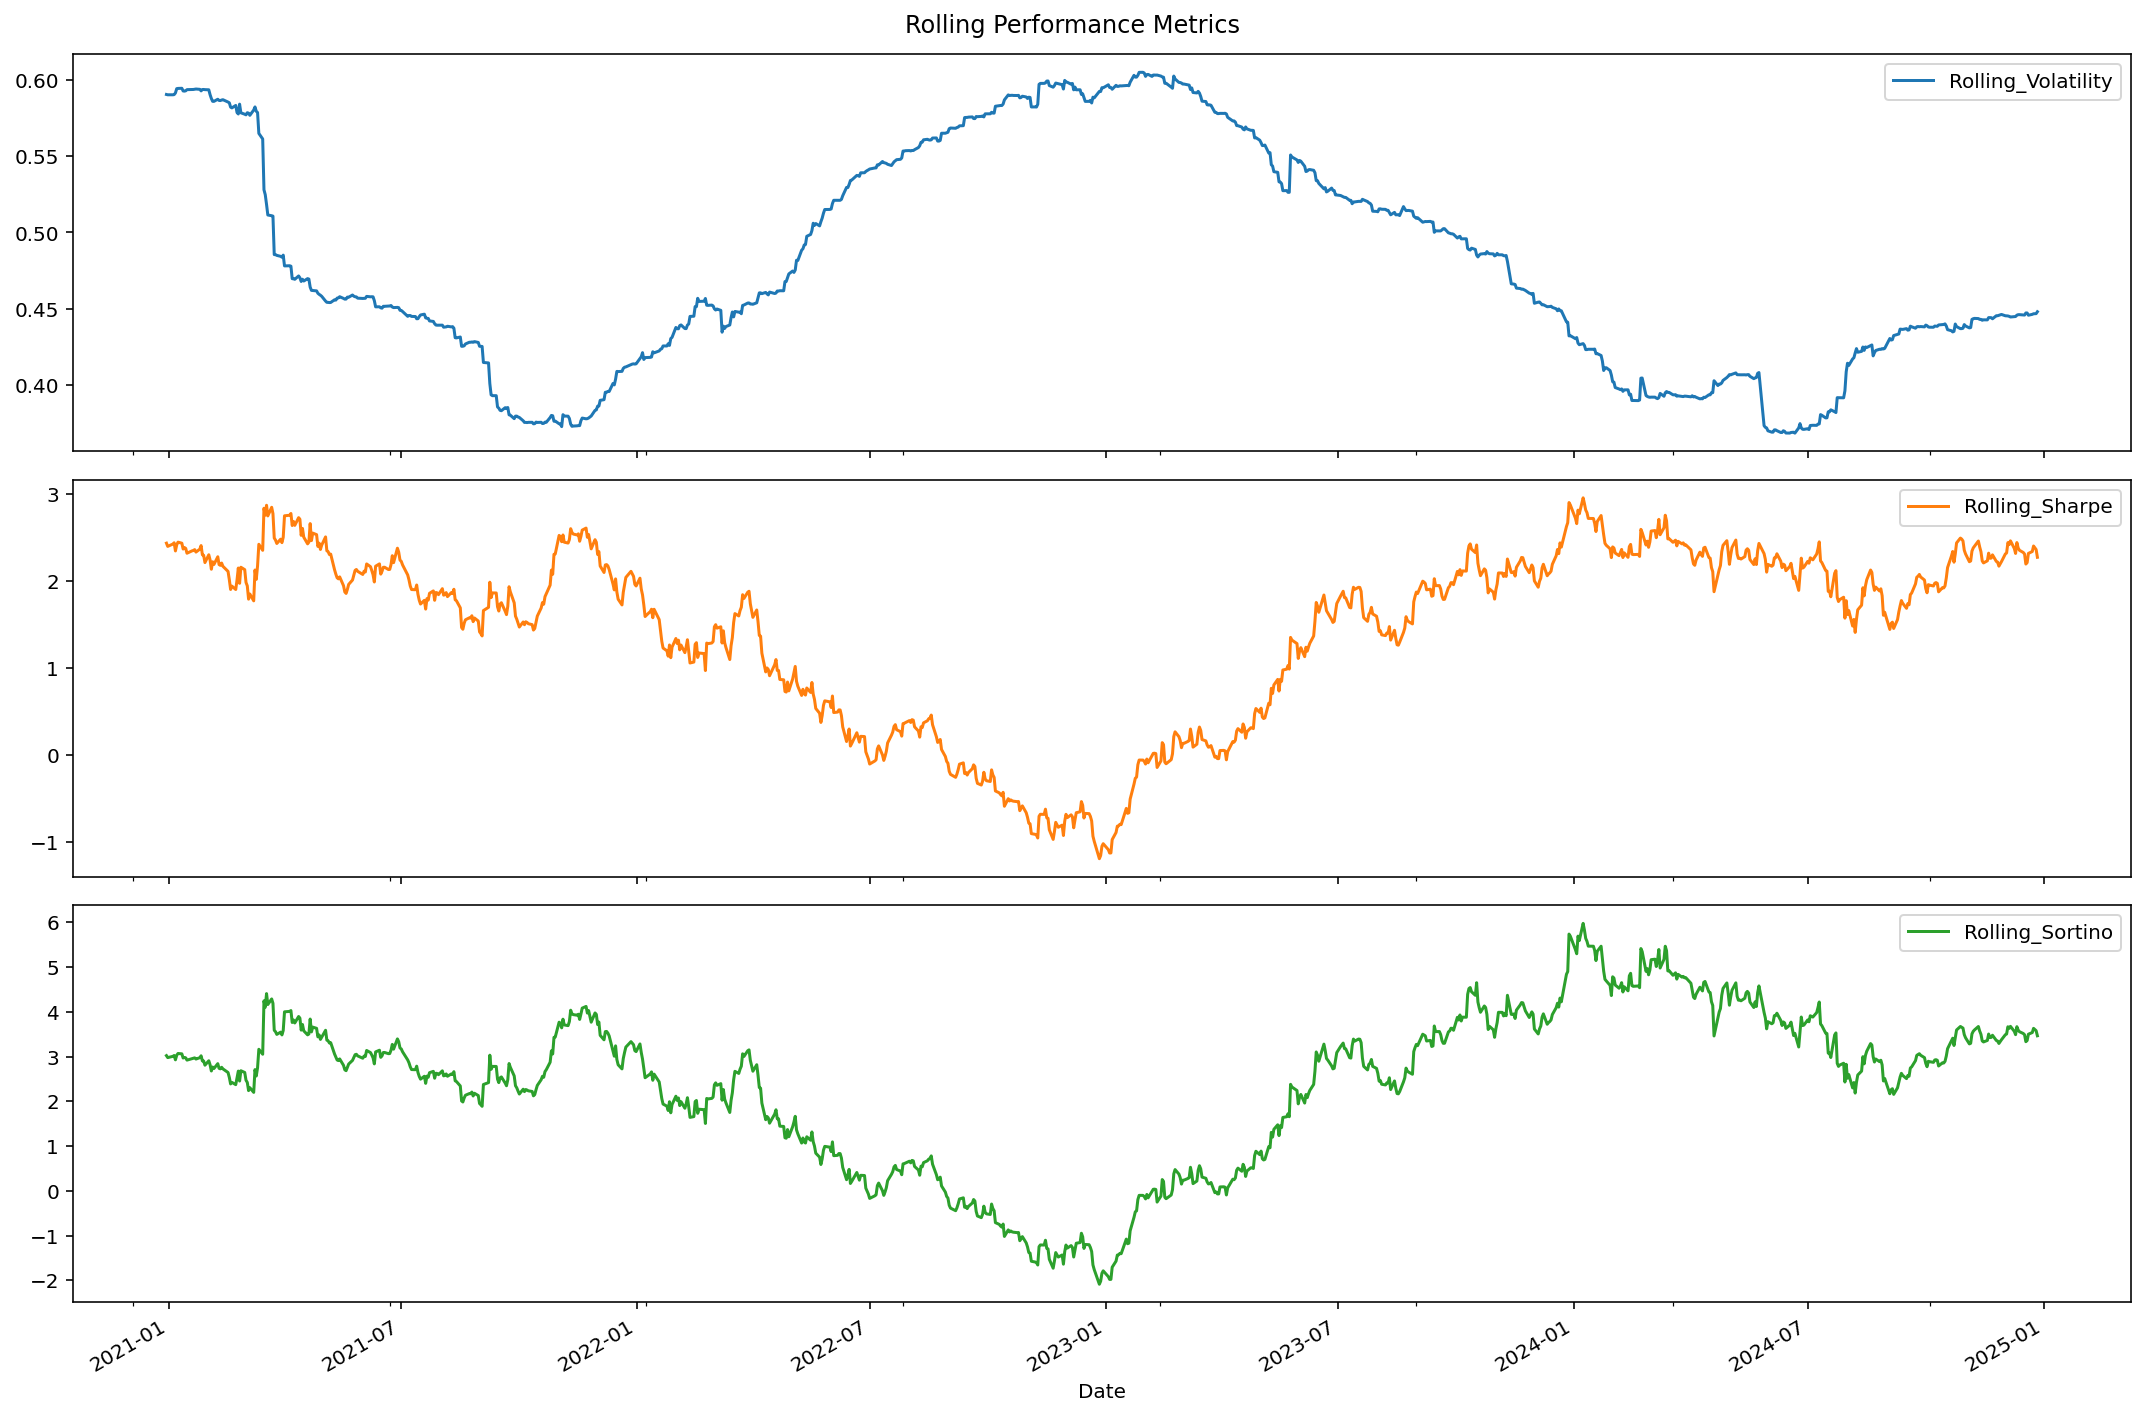

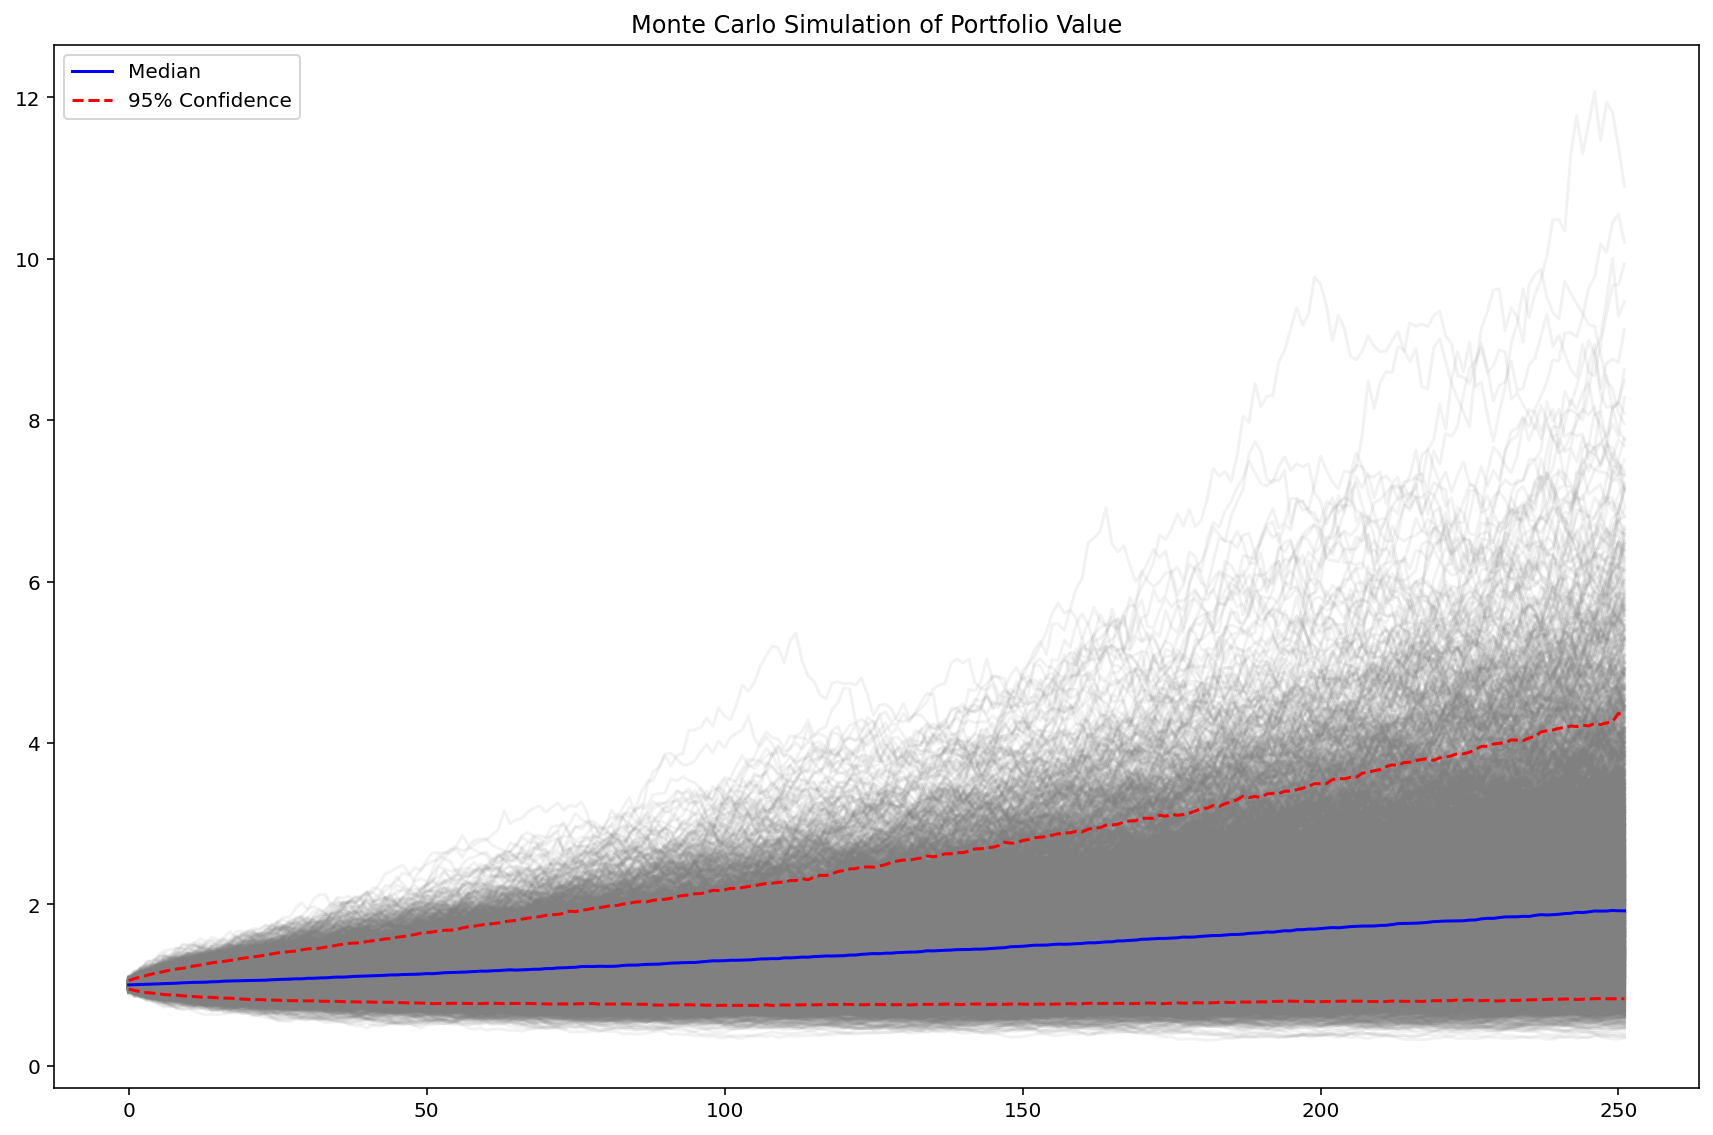

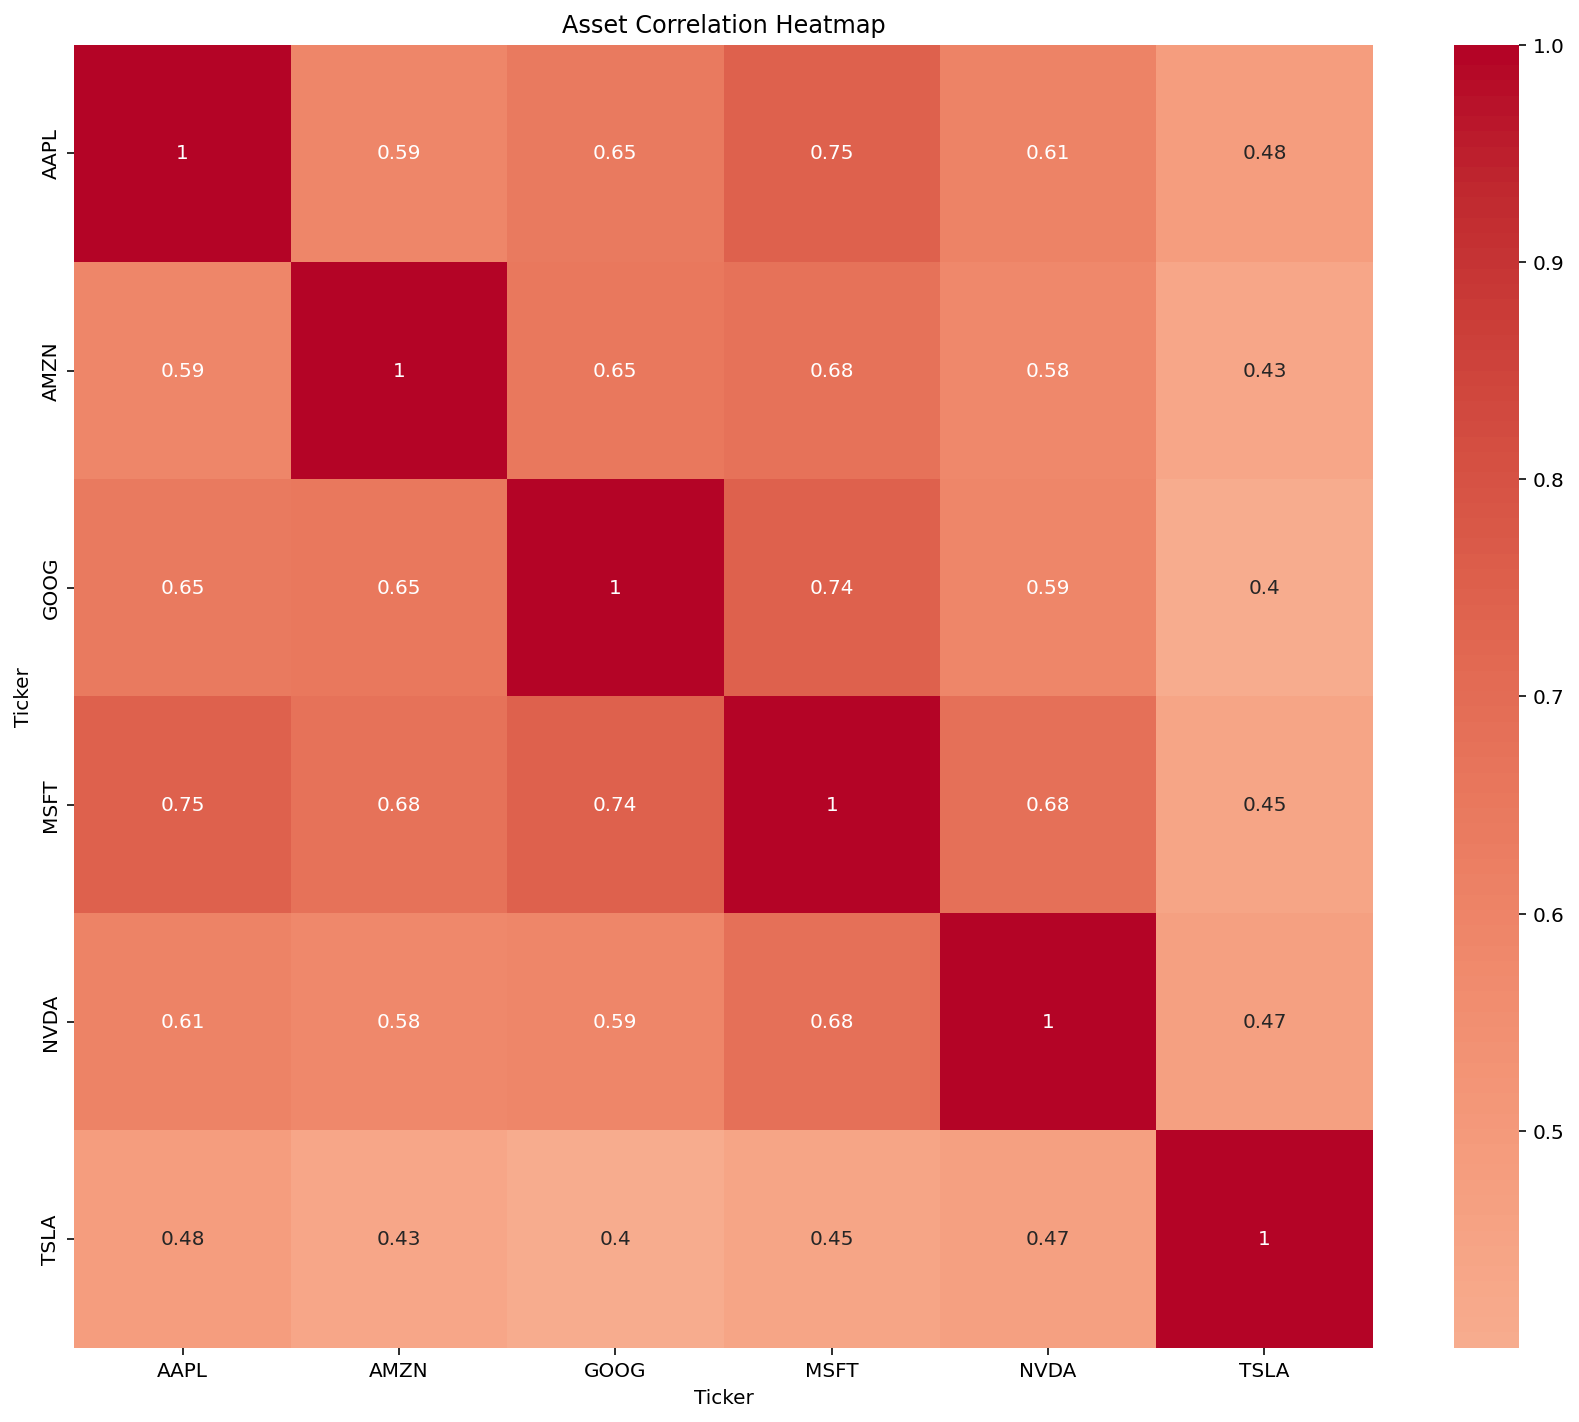

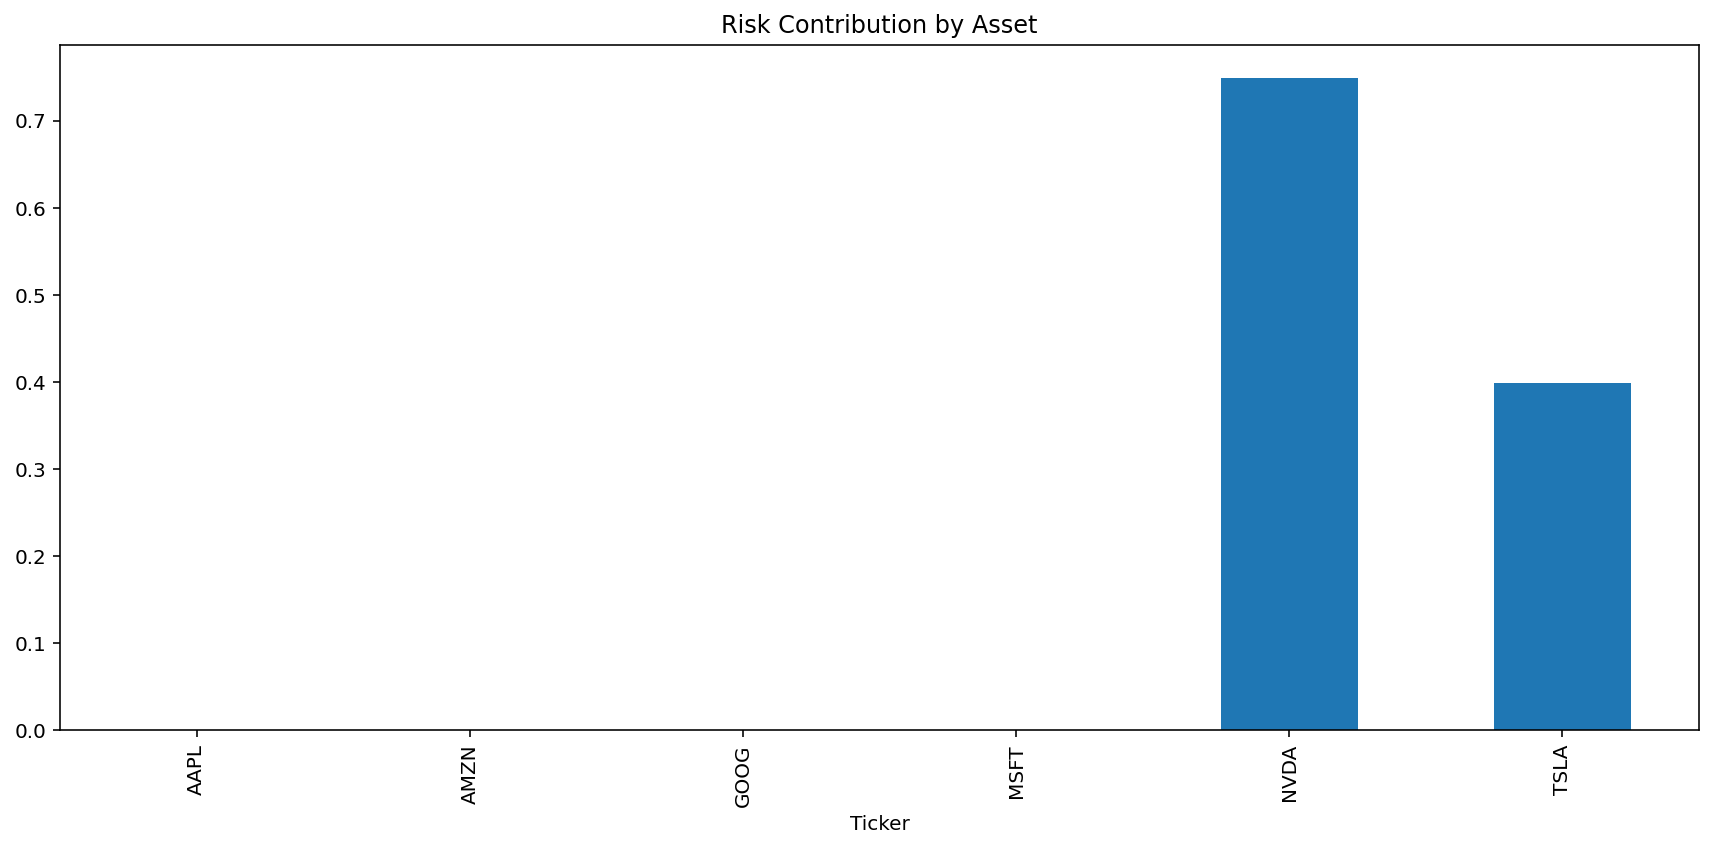

In [4]:
def run_portfolio_analysis_demo():
    """
    Comprehensive demonstration of the portfolio analysis functionality
    with detailed output printing
    """
    # Initialize portfolio analysis with sample data
    tickers = 'MSFT AAPL TSLA AMZN NVDA GOOG'
    
    print("\n" + "="*80)
    print("STARTING COMPREHENSIVE PORTFOLIO ANALYSIS")
    print("="*80)
    
    print(f"\nAnalyzing portfolio with tickers: {tickers}")
    print(f"Time period: 2020-2024")
    
    # Run the main analysis
    results = comprehensive_portfolio_analysis(
        tickers=tickers,
        start_date='2020',
        end_date='2024',
        risk_free_rate=0.04,
        confidence_level=0.95,
        rebalance_frequency='M',
        monte_carlo_sims=5000
    )
    
    # 1. Basic Portfolio Metrics
    print("\n" + "-"*40)
    print("1. BASIC PORTFOLIO METRICS")
    print("-"*40)
    
    print("\nLong-Only Portfolio Weights:")
    weights_df = pd.DataFrame({
        'Weight': results['long_only_sharpe']['weights']
    }, index=tickers.split())
    print(weights_df.round(4))
    
    print("\nPortfolio Sharpe Ratio:", 
          round(results['long_only_sharpe']['sharpe_ratio'], 4))
    
    # 2. Risk Metrics
    print("\n" + "-"*40)
    print("2. RISK METRICS")
    print("-"*40)
    
    for metric, value in results['risk_metrics'].items():
        print(f"{metric.replace('_', ' ')}: {value:.4f}")
    
    # 3. Rolling Analysis
    print("\n" + "-"*40)
    print("3. ROLLING METRICS SUMMARY")
    print("-"*40)
    
    rolling_summary = results['rolling_metrics'].describe()
    print("\nRolling Metrics Statistical Summary:")
    print(rolling_summary.round(4))
    
    # 4. Monte Carlo Simulation Results
    print("\n" + "-"*40)
    print("4. MONTE CARLO SIMULATION RESULTS")
    print("-"*40)
    
    conf_intervals = results['monte_carlo']['conf_intervals']
    print("\nFinal Portfolio Value Projections:")
    print(f"95% Confidence Interval Lower Bound: {conf_intervals['lower_95'][-1]:.4f}")
    print(f"Median Projection: {conf_intervals['median'][-1]:.4f}")
    print(f"95% Confidence Interval Upper Bound: {conf_intervals['upper_95'][-1]:.4f}")
    
    # 5. Correlation Analysis
    print("\n" + "-"*40)
    print("5. CORRELATION ANALYSIS")
    print("-"*40)
    
    print("\nAsset Correlation Matrix:")
    print(results['correlation_analysis'].round(4))
    
    # 6. Rebalancing Analysis
    print("\n" + "-"*40)
    print("6. REBALANCING ANALYSIS")
    print("-"*40)
    
    rebal_returns = results['rebalancing_analysis']
    print("\nRebalancing Returns Summary:")
    print(rebal_returns.describe().round(4))
    
    # 7. Portfolio Optimization Comparison
    print("\n" + "-"*40)
    print("7. PORTFOLIO OPTIMIZATION COMPARISON")
    print("-"*40)
    
    optimization_comparison = pd.DataFrame({
        'Long Only': results['long_only_sharpe']['weights'],
        'Short Allowed': results['short_allowed_sharpe']['weights'],
        'Limited Short': results['limited_short_sharpe']['weights']
    }, index=tickers.split())
    
    print("\nOptimization Strategy Weights Comparison:")
    print(optimization_comparison.round(4))
    
    # 8. Efficient Frontier Analysis
    print("\n" + "-"*40)
    print("8. EFFICIENT FRONTIER ANALYSIS")
    print("-"*40)
    
    ef_data = results['efficient_frontier']
    print("\nEfficient Frontier Points (Risk vs Return):")
    print(ef_data.round(4).head())
    
    # 9. Example of accessing specific portfolio metrics
    print("\n" + "-"*40)
    print("9. ACCESSING SPECIFIC METRICS (Examples)")
    print("-"*40)
    
    print("\nExample of accessing specific metrics:")
    print(f"Maximum Drawdown: {results['risk_metrics']['Max_Drawdown']:.4f}")
    print(f"Annual Volatility: {results['risk_metrics']['Annual_Volatility']:.4f}")
    print(f"Sharpe Ratio: {results['risk_metrics']['Sharpe_Ratio']:.4f}")
    
    # 10. Save results to file
    print("\n" + "-"*40)
    print("10. SAVING RESULTS")
    print("-"*40)
    
    # Save main results to CSV
    main_metrics = pd.DataFrame({
        'Metric': ['Sharpe_Ratio', 'Sortino_Ratio', 'CVaR', 'Annual_Volatility', 'Max_Drawdown'],
        'Value': [results['risk_metrics'][metric] for metric in ['Sharpe_Ratio', 'Sortino_Ratio', 'CVaR', 'Annual_Volatility', 'Max_Drawdown']]
    })
    main_metrics.to_csv('portfolio_metrics.csv', index=False)
    print("\nMain metrics saved to 'portfolio_metrics.csv'")
    
    # Save weights to CSV
    weights_df.to_csv('portfolio_weights.csv')
    print("Portfolio weights saved to 'portfolio_weights.csv'")
    
    # Save rolling metrics to CSV
    results['rolling_metrics'].to_csv('rolling_metrics.csv')
    print("Rolling metrics saved to 'rolling_metrics.csv'")
    
    print("\n" + "="*80)
    print("ANALYSIS COMPLETE")
    print("="*80)
    
    return results

# Example usage:
if __name__ == "__main__":
    # Run the complete analysis with all print statements
    results = run_portfolio_analysis_demo()
    
    # Example of accessing specific results after analysis
    print("\nExample of accessing specific results:")
    
    # Access optimal weights
    optimal_weights = results['long_only_sharpe']['weights']
    print("\nOptimal Weights:")
    
    # Access risk metrics
    print("\nRisk Metrics:")
    for metric, value in results['risk_metrics'].items():
        print(f"{metric}: {value:.4f}")
    
    # Access Monte Carlo simulation results
    print("\nMonte Carlo Simulation Final Values:")
    for percentile, value in zip(['5th', '50th', '95th'], 
                               [results['monte_carlo']['conf_intervals']['lower_95'][-1],
                                results['monte_carlo']['conf_intervals']['median'][-1],
                                results['monte_carlo']['conf_intervals']['upper_95'][-1]]):
        print(f"{percentile} percentile: {value:.4f}")
    
    # Plot key visualizations
    plt.show()  # Display all generated plots


STARTING COMPREHENSIVE PORTFOLIO ANALYSIS

Analyzing portfolio with tickers: MSFT AAPL TSLA AMZN NVDA GOOG
Time period: 2020-2024

----------------------------------------
1. BASIC PORTFOLIO METRICS
----------------------------------------

Long-Only Portfolio Weights:
      Weight
MSFT  0.0000
AAPL  0.0000
TSLA  0.0000
AMZN  0.0000
NVDA  0.7006
GOOG  0.2994

Portfolio Sharpe Ratio: 1.5411

----------------------------------------
2. RISK METRICS
----------------------------------------
Sharpe Ratio: 1.4617
Sortino Ratio: 1.4822
CVaR: 0.0684
Annual Volatility: 0.5038
Max Drawdown: 0.6110

----------------------------------------
3. ROLLING METRICS SUMMARY
----------------------------------------

Rolling Metrics Statistical Summary:
       Rolling_Volatility  Rolling_Sharpe  Rolling_Sortino
count           1005.0000       1005.0000        1005.0000
mean               0.4810          1.4638           2.3748
std                0.0731          1.0098           1.7271
min                0

<Figure size 1080x720 with 0 Axes>

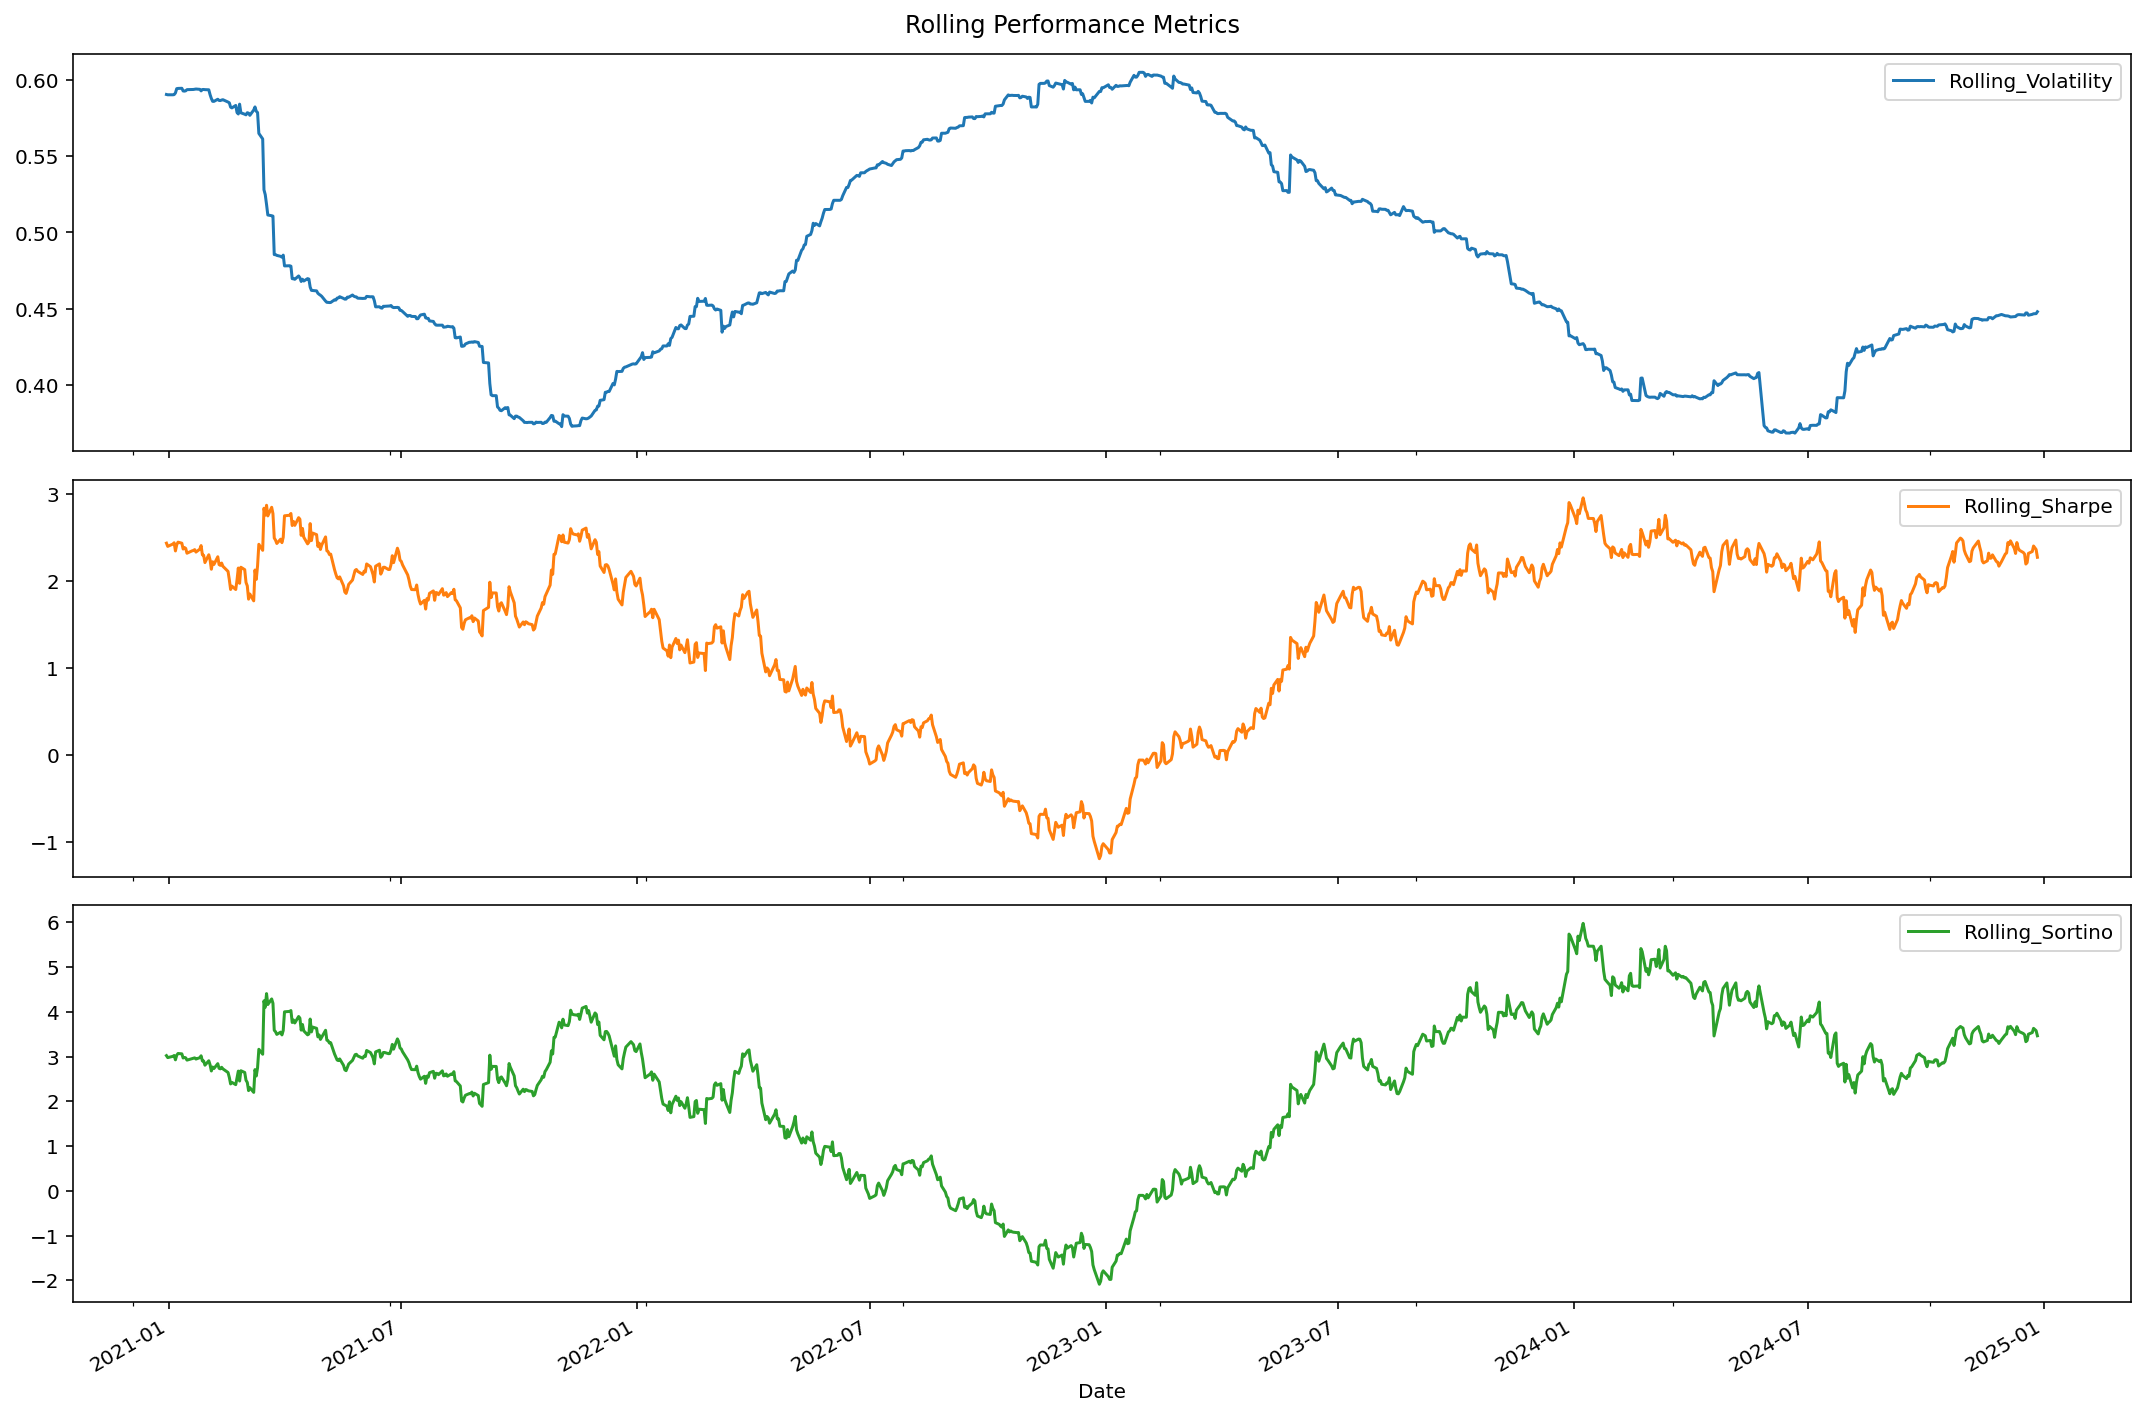

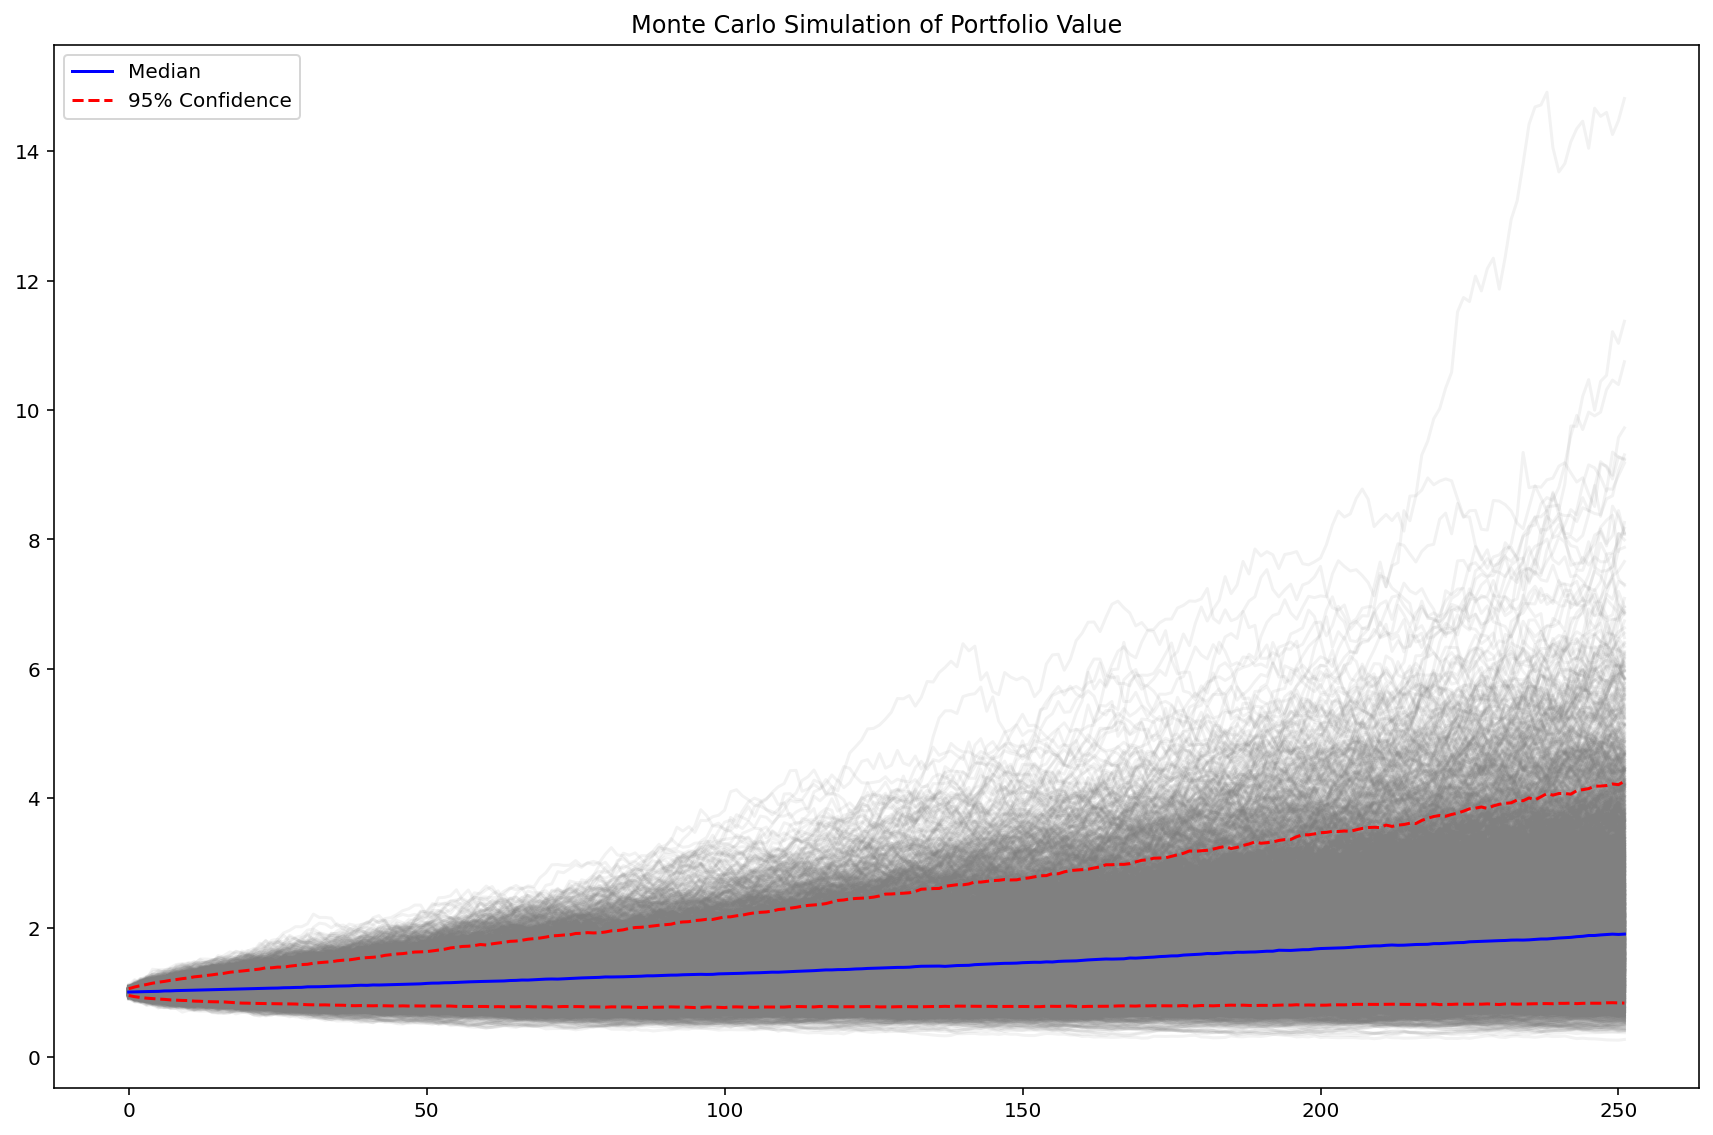

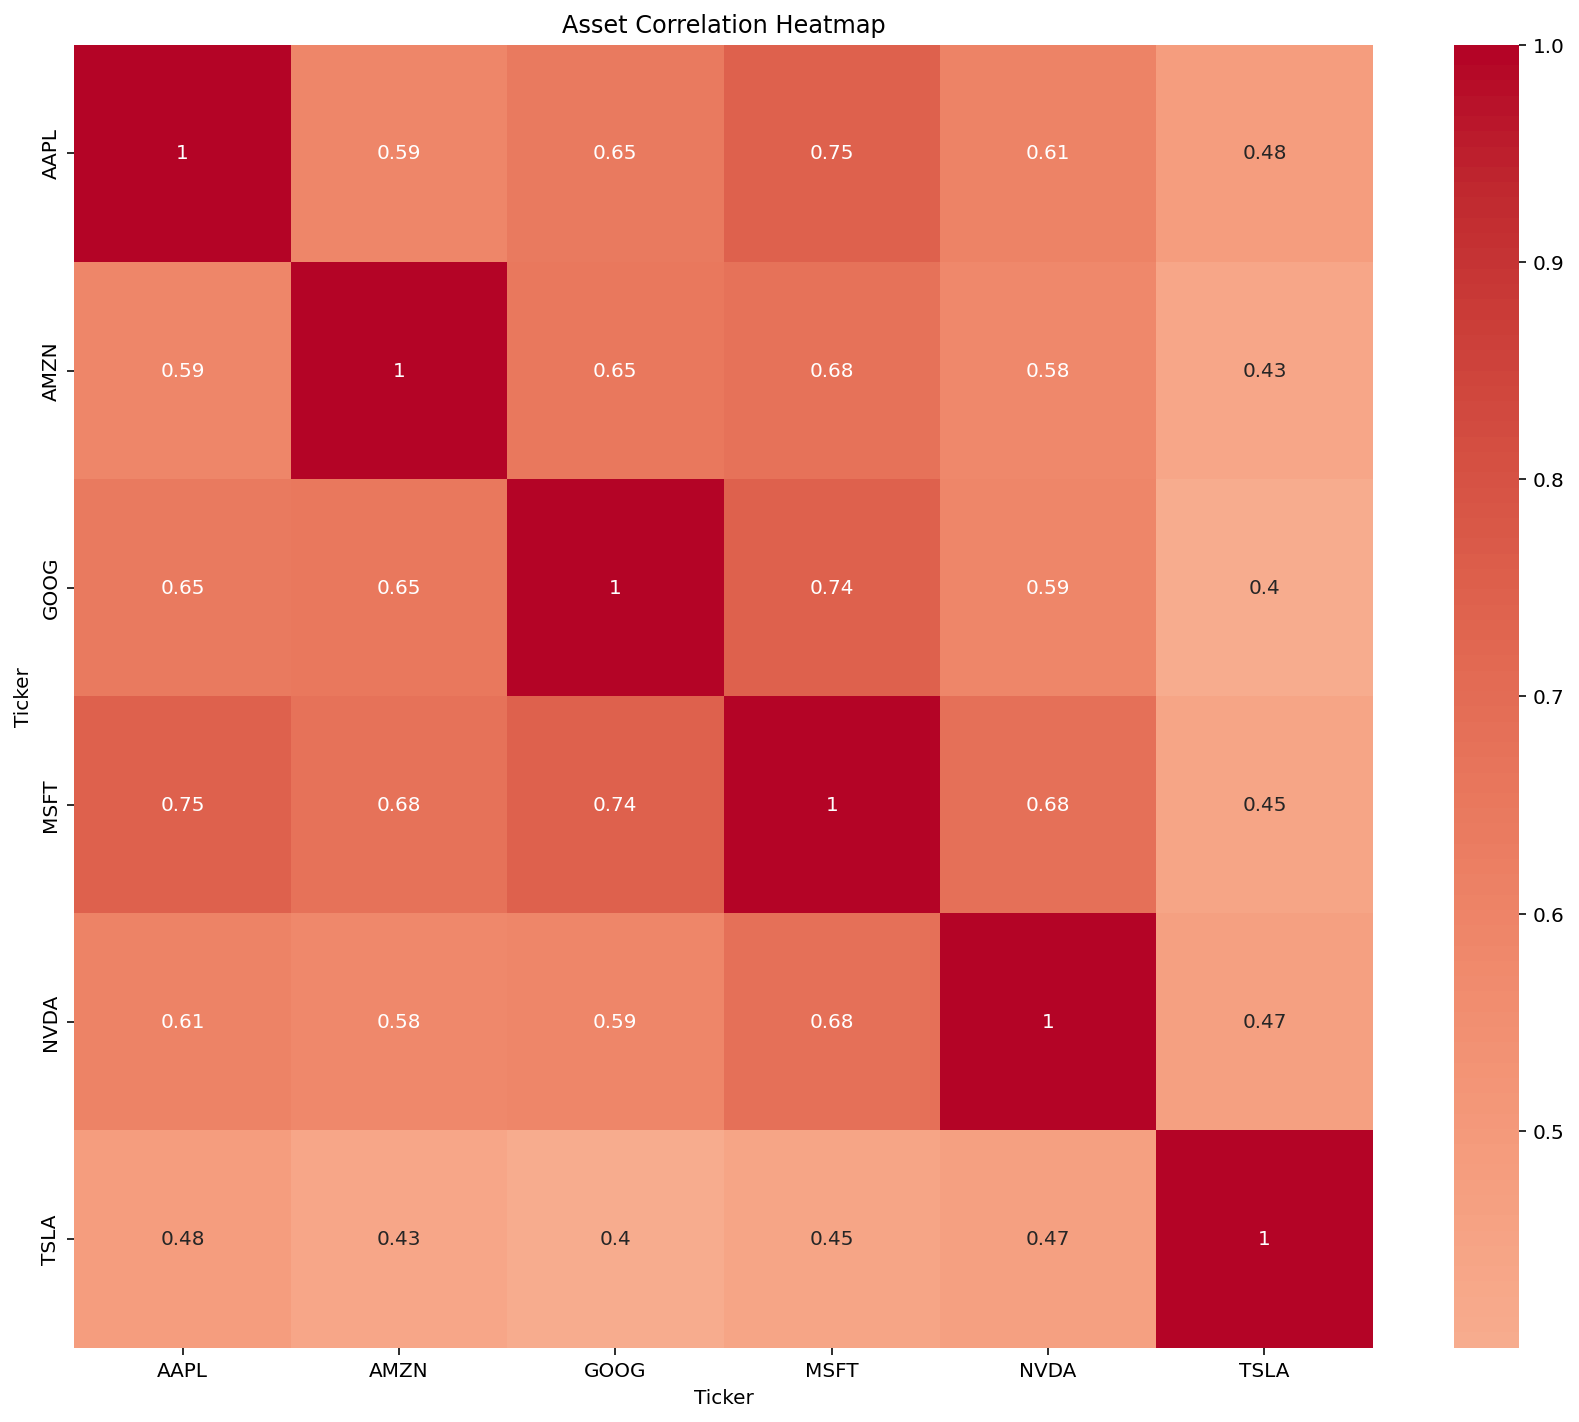

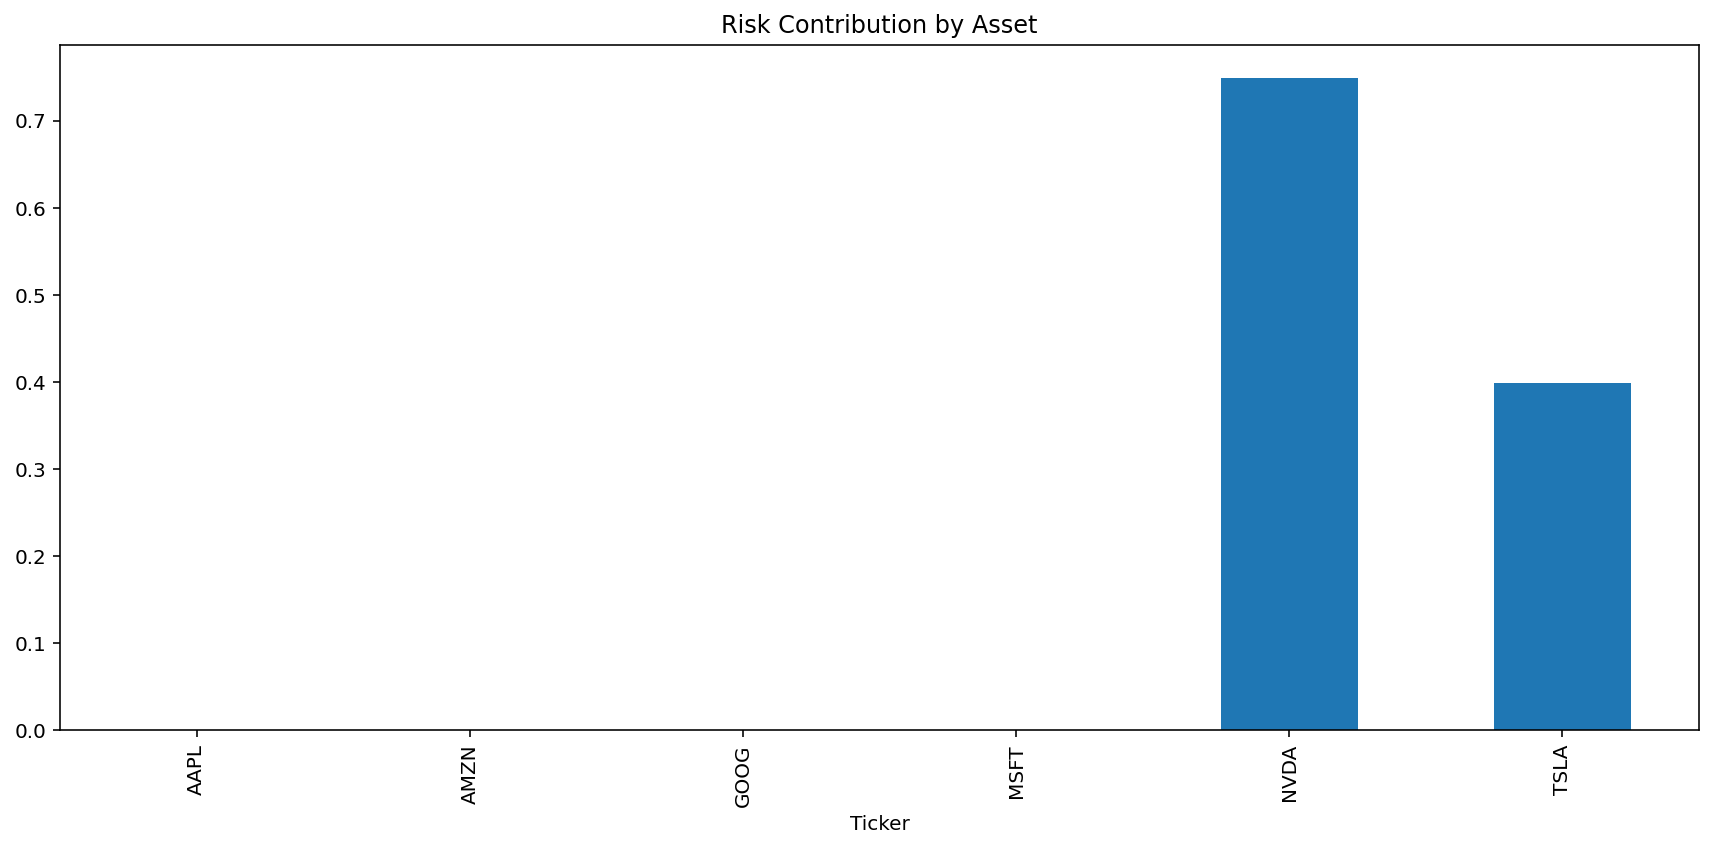

In [5]:
# Run the complete analysis with all print statements
results = run_portfolio_analysis_demo()

# Access specific results as needed
optimal_weights = results['long_only_sharpe']['weights']
risk_metrics = results['risk_metrics']
monte_carlo_results = results['monte_carlo']